# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.1.0+cu121


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

folder_path = '/content/drive/My Drive/Colab Notebooks/COVID-19 Radiography Database'
# You can now use the folder_path to access the contents of the folder

# Preparing Training and Test Sets

In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['normal', 'viral', 'covid']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']

        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)

        self.image_dirs = image_dirs
        self.transform = transform


    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])


    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Prepare DataLoader

In [ ]:
train_dirs = {
    'normal': '/content/drive/My Drive/Colab Notebooks/COVID-19 Radiography Database/normal',
    'viral': '/content/drive/My Drive/Colab Notebooks/COVID-19 Radiography Database/viral',
    'covid': '/content/drive/My Drive/Colab Notebooks/COVID-19 Radiography Database/covid'
}

# Now you can use train_dirs to access your dataset
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1248 normal examples
Found 1315 viral examples
Found 1286 covid examples


In [ ]:
test_dirs = {
    'normal': '/content/drive/My Drive/Colab Notebooks/COVID-19 Radiography Database/test/normal',
    'viral': '/content/drive/My Drive/Colab Notebooks/COVID-19 Radiography Database/test/viral',
    'covid': '/content/drive/My Drive/Colab Notebooks/COVID-19 Radiography Database/test/covid'
}

# Now you can use test_dirs to access your dataset
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 642
Number of test batches 15


# Data Visualization

In [ ]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()



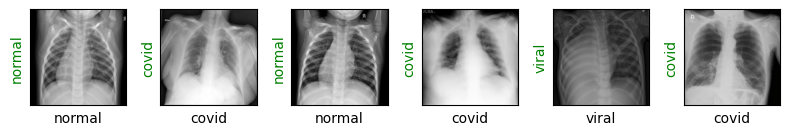

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

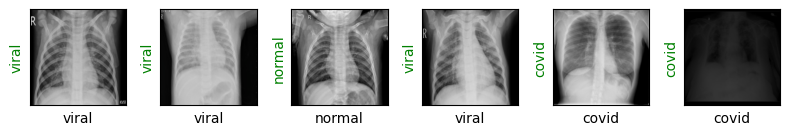

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [ ]:
resnet18= torchvision.models.resnet18(pretrained=True)
print(resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.fc=torch.nn.Linear(in_features=512, out_features=3)
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(resnet18.parameters(), lr=3e-5)


In [ ]:
def show_preds():
  resnet18.eval()
  images, labels= next(iter(dl_test))
  outputs=resnet18(images)
  _, preds=torch.max(outputs, 1)
  show_images(images, labels, preds)

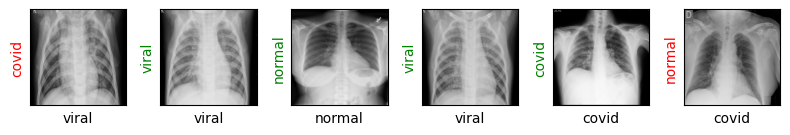

In [ ]:
show_preds()

# Training the Model

In [ ]:
def train(epochs):
  print('Starting training..')
  for e in range(0, epochs):
    print('='*20)
    print(f'Starting epoch {e+1}/{epochs}')

    train_loss=0

    resnet18.train()

    for train_step, (images, labels) in enumerate(dl_train):
      optimizer.zero_grad()
      outputs= resnet18(images)
      loss=loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()

      if train_step % 20 ==0:
        print('Evaluating at step', train_step)
        acc=0
        val_loss=0
        resnet18.eval()

        for val_step, (images, labels) in enumerate(dl_test):
          outputs=resnet18(images)
          loss=loss_fn(outputs, labels)
          val_loss += loss.item()

          _, preds=torch.max(outputs, 1)
          acc += sum((preds==labels).numpy())
        val_loss/=(val_step + 1)
        acc = acc / len(test_dataset)

        print(f'Val loss: {val_loss: .4f}, Acc: {acc:.4f}')
        show_preds()

        resnet18.train()

        if acc > 0.95:
          print('Performance condition satisfied..')
          return
  train_loss/=(train_step +1)
  print(f'Training loss: {train_loss:.4f}')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Val loss:  1.0894, Acc: 0.3667


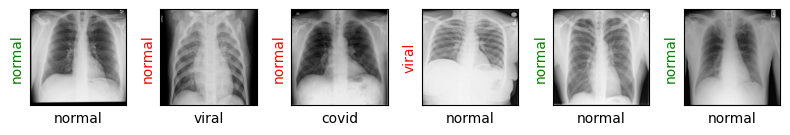

Evaluating at step 20
Val loss:  0.9504, Acc: 0.5111


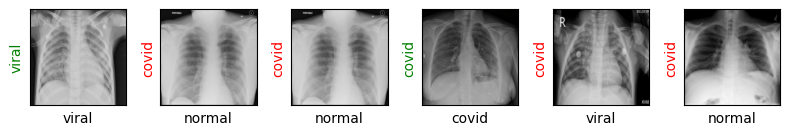

Evaluating at step 40
Val loss:  0.8041, Acc: 0.7333


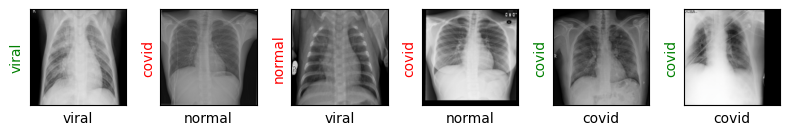

Evaluating at step 60
Val loss:  1.0949, Acc: 0.6667


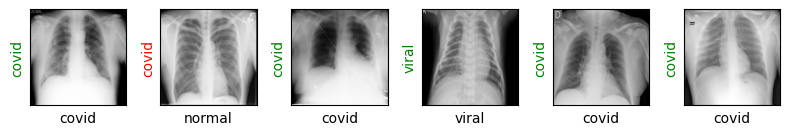

Evaluating at step 80
Val loss:  0.7101, Acc: 0.7222


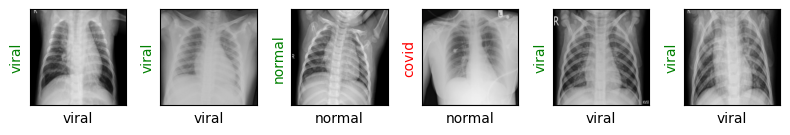

Evaluating at step 100
Val loss:  0.4566, Acc: 0.7667


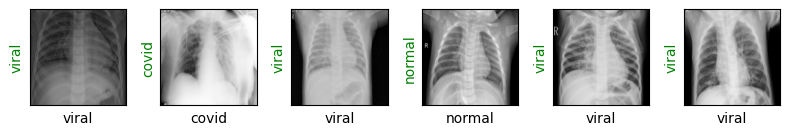

Evaluating at step 120
Val loss:  0.5427, Acc: 0.7333


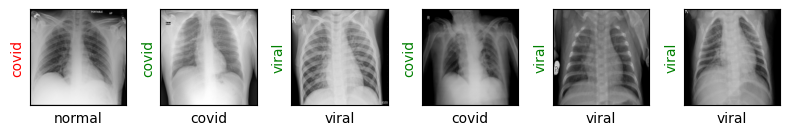

Evaluating at step 140
Val loss:  0.6826, Acc: 0.7333


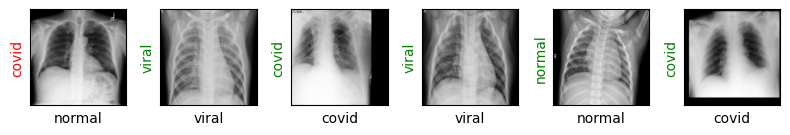

Evaluating at step 160
Val loss:  0.4334, Acc: 0.8222


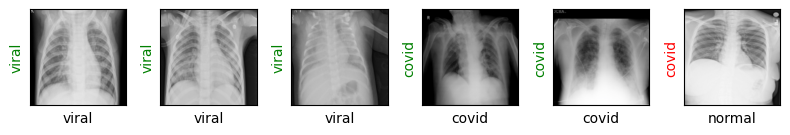

Evaluating at step 180
Val loss:  0.7973, Acc: 0.7111


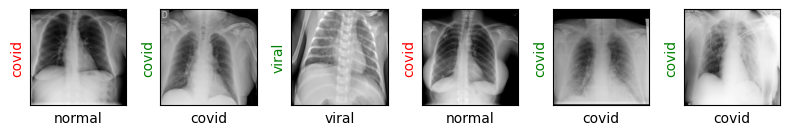

Evaluating at step 200
Val loss:  0.9341, Acc: 0.7222


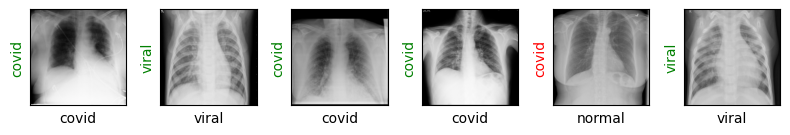

Evaluating at step 220
Val loss:  0.4406, Acc: 0.7889


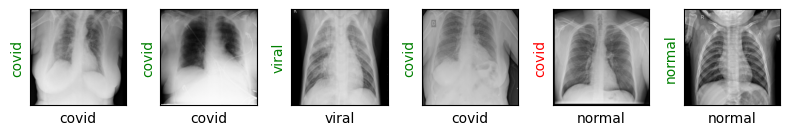

Evaluating at step 240
Val loss:  0.7155, Acc: 0.7889


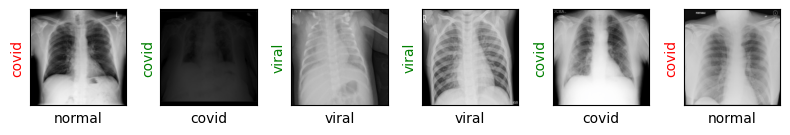

Evaluating at step 260
Val loss:  0.5156, Acc: 0.7889


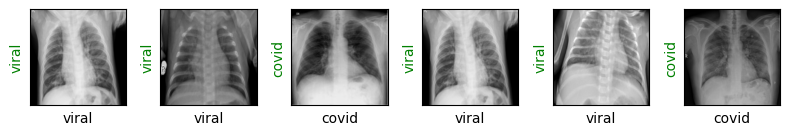

Evaluating at step 280
Val loss:  0.4561, Acc: 0.8556


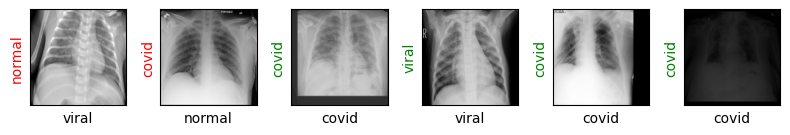

Evaluating at step 300
Val loss:  0.5408, Acc: 0.8000


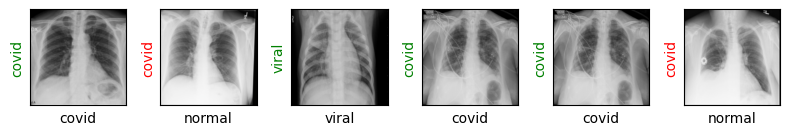

Evaluating at step 320
Val loss:  0.4200, Acc: 0.8000


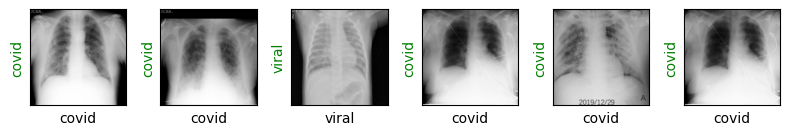

Evaluating at step 340
Val loss:  0.3098, Acc: 0.8333


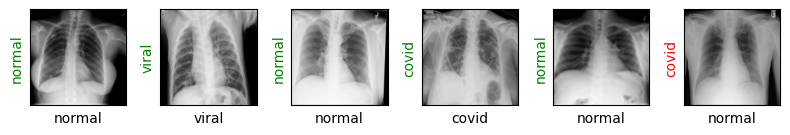

Evaluating at step 360
Val loss:  0.3073, Acc: 0.8111


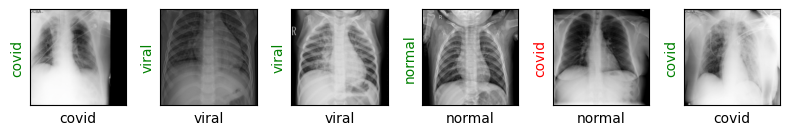

Evaluating at step 380
Val loss:  0.5733, Acc: 0.7444


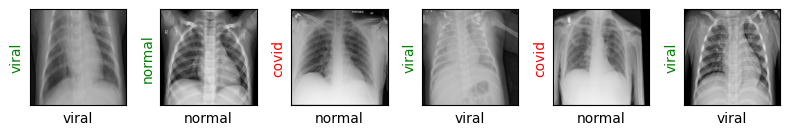

Evaluating at step 400
Val loss:  0.9896, Acc: 0.6778


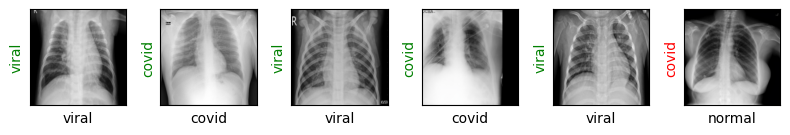

Evaluating at step 420
Val loss:  0.3628, Acc: 0.8444


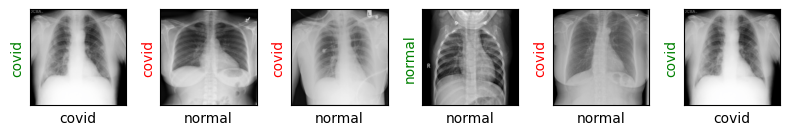

Evaluating at step 440
Val loss:  0.7384, Acc: 0.7000


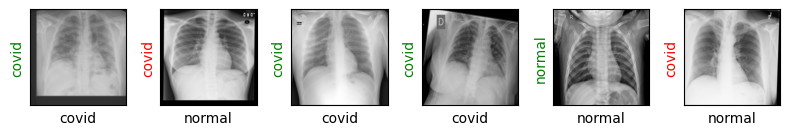

Evaluating at step 460
Val loss:  0.3762, Acc: 0.8333


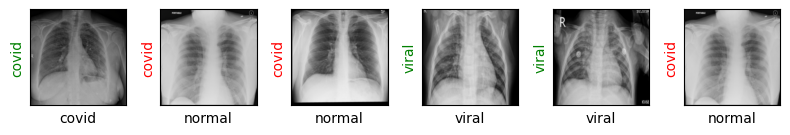

Evaluating at step 480
Val loss:  0.5110, Acc: 0.7778


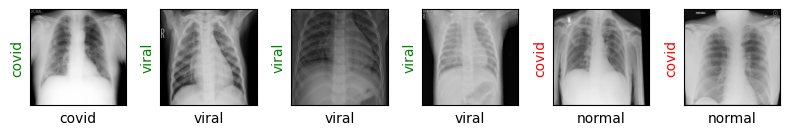

Evaluating at step 500
Val loss:  0.4046, Acc: 0.8444


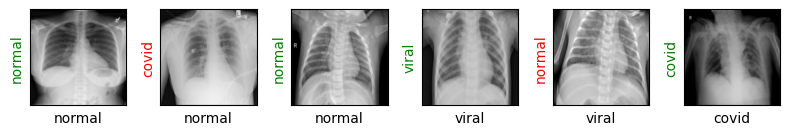

Evaluating at step 520
Val loss:  0.3223, Acc: 0.8778


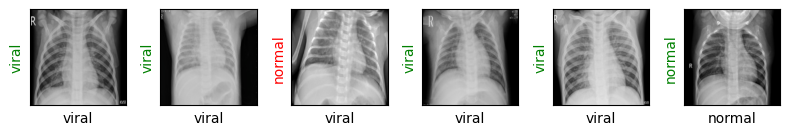

Evaluating at step 540
Val loss:  0.4721, Acc: 0.8444


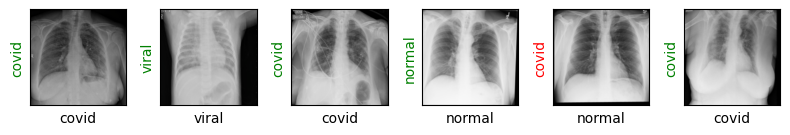

Evaluating at step 560
Val loss:  0.3967, Acc: 0.7889


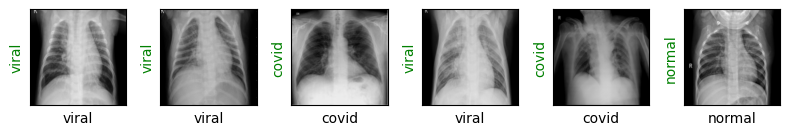

Evaluating at step 580
Val loss:  0.4039, Acc: 0.8111


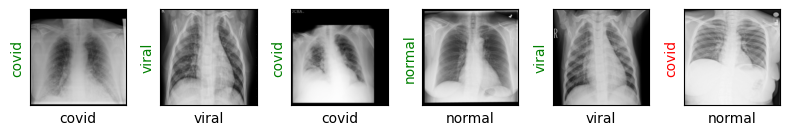

Evaluating at step 600
Val loss:  0.2595, Acc: 0.8667


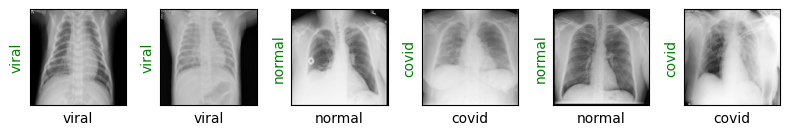

Evaluating at step 620
Val loss:  0.2145, Acc: 0.9111


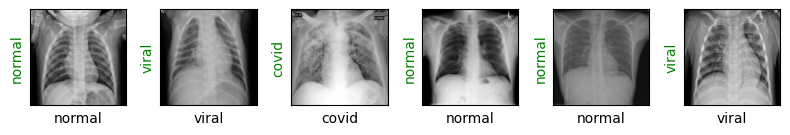

Evaluating at step 640
Val loss:  0.3286, Acc: 0.8556


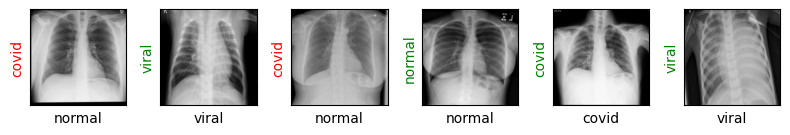

Training loss: 0.2652


In [ ]:
train(epochs=1)

# Final Results

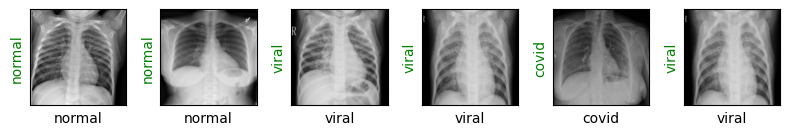

In [ ]:
show_preds()